# EIT Continous Model - Solver

In [1]:
from module1_mesh import*
from module2_forward import*
from module3_inverse import*
from module4_auxiliar import*
import matplotlib.pyplot as plt
import time
import pandas as pd
#from fenics import*

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


## Defining mesh

In [2]:
mesh_inverse, mesh_direct=MyMesh(r=1, n=8, n_vertex=321)
mesh_direct=refine(mesh_direct)

1070


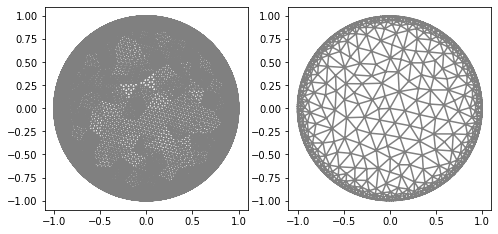

In [3]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plot(mesh_direct);
plt.subplot(1,2,2)
plot(mesh_inverse);
print(mesh_inverse.num_cells())

In [4]:
"Current"
n_g=6
I_all=current_method(n_g, value=1, method=1)

In [5]:
"Checking hyphotesis"
Verifyg(I_all, mesh_direct)
Verifyg(I_all, mesh_inverse)

Integral boundary: 1.8604909279851256e-16 0
Integral boundary: 1.6479873021779667e-17 1
Integral boundary: -7.91033905045424e-16 2
Integral boundary: 4.2760933682828295e-16 3
Integral boundary: 3.677613769070831e-16 4
Integral boundary: -6.271025365656158e-16 5
Integral boundary g(0)*g(1): 0.0
Integral boundary g(0)*g(2): 0.0
Integral boundary g(0)*g(3): 0.0
Integral boundary g(0)*g(4): 0.0
Integral boundary g(0)*g(5): 0.0
Integral boundary g(1)*g(2): 0.0
Integral boundary g(1)*g(3): 0.0
Integral boundary g(1)*g(4): 0.0
Integral boundary g(1)*g(5): 0.0
Integral boundary g(2)*g(3): 0.0
Integral boundary g(2)*g(4): 0.0
Integral boundary g(2)*g(5): 0.0
Integral boundary g(3)*g(4): 0.0
Integral boundary g(3)*g(5): 0.0
Integral boundary g(4)*g(5): 0.0
Integral boundary: 2.3418766925686896e-16 0
Integral boundary: 7.979727989493313e-17 1
Integral boundary: -6.331740687315346e-16 2
Integral boundary: 3.3480163086352377e-16 3
Integral boundary: 2.5153490401663703e-16 4
Integral boundary: -5.49

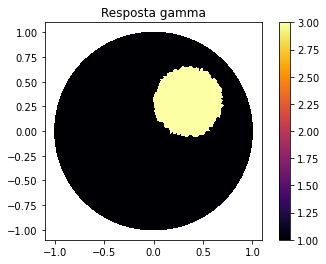

In [6]:
"Defining gamma"
ValuesCells0=GammaCircle(mesh_direct,3,1,0.35, 0.35, 0.30); #malha, cond_interna, cond_externa, raio.
gamma0=CellFunction(mesh_direct, values=ValuesCells0);#Pega o vetor e transforma em uma função

"Plot"
V_DG=FiniteElement('DG',mesh_inverse.ufl_cell(),0)
gamma_direct=plot_figure(mesh_direct, V_DG, gamma0, name="Resposta gamma");

In [7]:
"ForwardProblem"
VD=FiniteElement('CG',mesh_direct.ufl_cell(),1) 

ForwardObject=ForwardProblem(mesh_direct)
start_time = time.clock()
list_u0=ForwardObject.solve_forward(VD, gamma0, I_all)
print (time.clock() - start_time, "seconds")
print ((time.clock() - start_time)/60, "minutes")

u0_boundary=ForwardObject.boundary_array(mesh_inverse) #Boundary data in the mesh_inverse

1.40625 seconds
0.0234375 minutes


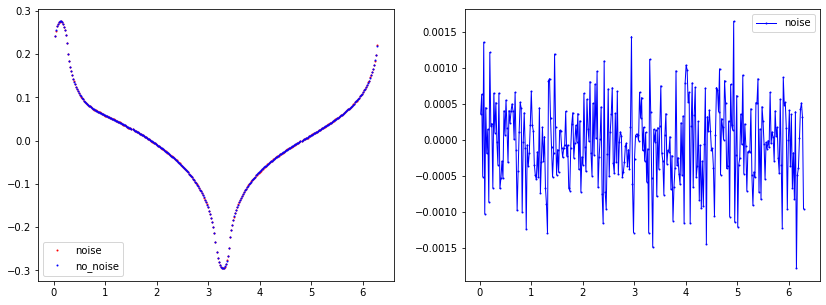

In [8]:
"Noise Parameters"
noise_level=0.005
noise_type='uniform'
seed=1
u0_boundary=ForwardObject.add_noise(noise_level, noise_type, seed, mesh_inverse)
end=len(u0_boundary)
    
index=0 #Index solution plot
if noise_level>1E-5:
    u0_boundary_c=ForwardObject.boundary_array(mesh_inverse, concatenate=False)
    u_dados_noise=u0_boundary[0:int(end/n_g)]
    data_u0=plot_boundary(mesh_inverse, data=u0_boundary_c[index], name='boundary u0_0', line=0, plot=False)
    data_u0_noise=plot_boundary(mesh_inverse, data=u_dados_noise, name='boundary u0_0', line=0, plot=False)
    
    plt.figure(figsize=(14, 5))
    plt.subplot(1,2,1)
    plt.plot(data_u0_noise[:,0], data_u0_noise[:,1], linewidth=0,  marker='.', markersize=2, label="noise", color='red');
    plt.plot(data_u0[:,0], data_u0[:,1], linewidth=0,  marker='.', markersize=2, label="no_noise", color="blue");
    plt.legend()
   
    plt.subplot(1,2,2)
    plt.plot(data_u0[:,0], data_u0[:,1]-data_u0_noise[:,1], linewidth=1,  marker='.', markersize=2, label="noise", color="blue");
    plt.legend()
    
    plt.show()
    

### Inverse Solver

In [18]:
"Object"
VI=FiniteElement('CG',mesh_inverse.ufl_cell(),1) 
InverseObject=InverseProblem(mesh_inverse, VI, u0_boundary, I_all)

"Solver Parameters"
InverseObject.set_solverconfig(step_limit=100)
InverseObject.set_NewtonParameters(mu_i=0.90, mumax=0.999, nu=0.99, R=0.999)
#InverseObject.set_InnerParameters(inner_method='Landweber', land_a=20)
InverseObject.set_InnerParameters(inner_method='ME', ME_reg=5E-2)
#InverseObject.set_InnerParameters(inner_method='CG')
#InverseObject.set_InnerParameters(inner_method='LM', LM_c0=0.95, LM_q=0.05)
#InverseObject.set_InnerParameters(inner_method='Tikhonov', Tik_c0=0.95, Tik_q=0.05)

"Noise Parameters"
tau=1.2
InverseObject.set_NoiseParameters(tau=tau, noise_level=noise_level)
print(f"Discrepance stop {tau*noise_level*100}% residue")

"Extra Parameters"
InverseObject.set_answer(gamma0, mesh_direct)
InverseObject.weight_value=False
#MyCellsgamma_k=np.ones(mesh_inverse.num_cells())*2.0
#InverseObject.set_firstguess(MyCellsgamma_k)

Discrepance stop 0.6% residue


In [19]:
start_time = time.clock()
InverseObject.solve_inverse()
print (time.clock() - start_time, "seconds")
print ((time.clock() - start_time)/60, "minutes")

Error (%)= 52.64400745794586 Residuo (%)= 22.22375023482952  passo: 0 Inner step:  0
mu_n 0.9
Error (%)= 51.24144181173581 Residuo (%)= 18.43282585491119  passo: 1 Inner step:  2
mu_n 0.9
Error (%)= 50.0198677348958 Residuo (%)= 15.252495169266373  passo: 2 Inner step:  2
mu_n 0.8991
Error (%)= 48.95414741028717 Residuo (%)= 12.595700154410288  passo: 3 Inner step:  2
mu_n 0.8982009
Error (%)= 48.01370652461131 Residuo (%)= 10.384950891452352  passo: 4 Inner step:  2
mu_n 0.8973026990999999
Error (%)= 47.162614745625916 Residuo (%)= 8.552097262666685  passo: 5 Inner step:  2
mu_n 0.8964053964008999
Error (%)= 46.35573317876679 Residuo (%)= 7.037563291300477  passo: 6 Inner step:  2
mu_n 0.895508991004499
Error (%)= 45.525640807894355 Residuo (%)= 5.788292070229575  passo: 7 Inner step:  2
mu_n 0.8946134820134944
Error (%)= 44.551701465710856 Residuo (%)= 4.747089244356652  passo: 8 Inner step:  2
mu_n 0.893718868531481
Error (%)= 43.328861871958765 Residuo (%)= 3.8302775920798067  pass

In [20]:
"Getting the result"
gamma_k=InverseObject.gamma_k

"Getting data_summary"
innerstep_vec=InverseObject.innerstep_vec
res_vec=InverseObject.res_vec
mun_vec=InverseObject.mun_vec
error_vec=InverseObject.error_vec

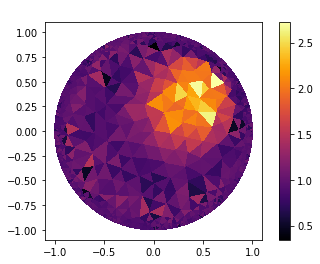

In [21]:
"Plot result"
V_DG=FiniteElement('DG',mesh_inverse.ufl_cell(),0)
gamma_k=plot_figure(mesh_inverse, V_DG, gamma_k, name=" ");

jet


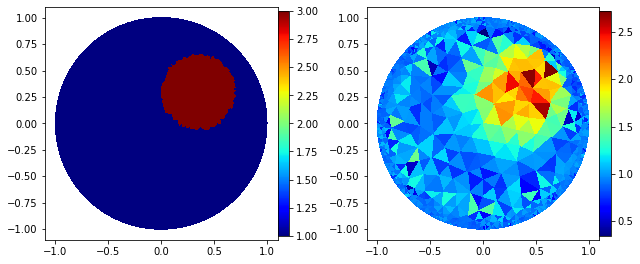

In [22]:
"Fancy plot"
cmap=['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']
cmap=cmap[126]#51 63 90 94 126 164 111
#cmap='inferno'
#print(cmap)
fig=plt.figure(figsize=(9, 9))
plt.subplot(1,2,1);
p=plot(gamma_direct);
p.set_cmap(cmap)
plt.colorbar(p,fraction=0.046, pad=0.0);

plt.subplot(1,2,2);
p=plot(gamma_k);
p.set_cmap(cmap);
plt.colorbar(p,fraction=0.046, pad=0.0);
fig.tight_layout()
print(cmap)

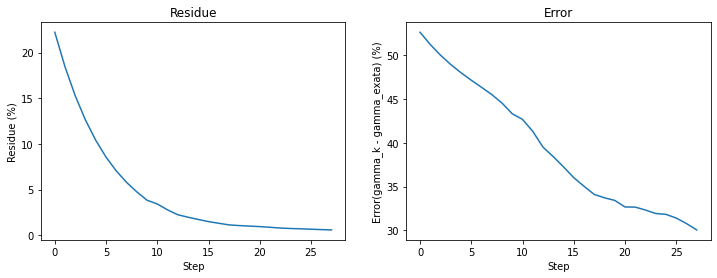

In [23]:
plt.figure(figsize=(12, 4));

"Subplot 1"
plt.subplot(1,2,1)
plt.ylabel('Residue (%)');
plt.xlabel('Step');
plt.title('Residue');
plt.plot(range(0,len(res_vec)), res_vec);

"Subplot 2"
plt.subplot(1,2,2)
plt.ylabel('Error(gamma_k - gamma_exata) (%)');
plt.xlabel('Step');
plt.title('Error');
plt.plot(range(0,len(error_vec)), error_vec);

In [24]:
summary_data=np.vstack((error_vec, res_vec, innerstep_vec, mun_vec))
data=pd.DataFrame(summary_data.T)
experiments=["Error (%)", "Residue (%) ", "Inner Step", "mu_n"]
data.columns = experiments
data

,Error (%),Residue (%),Inner Step,mu_n
0,52.644007,22.223750,0.0,0.000000
1,51.241442,18.432826,2.0,0.900000
2,50.019868,15.252495,2.0,0.900000
3,48.954147,12.595700,2.0,0.899100
4,48.013707,10.384951,2.0,0.898201
5,47.162615,8.552097,2.0,0.897303
6,46.355733,7.037563,2.0,0.896405
7,45.525641,5.788292,2.0,0.895509
8,44.551701,4.747089,2.0,0.894613
9,43.328862,3.830278,2.0,0.893719
